In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import specgram
from scipy.io import wavfile
from skimage.feature import peak_local_max
import librosa
import pydub

In [8]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [9]:
path = 'C:\\Users\\pizza\\Google Drive\\1_Break_Spots\\'

In [10]:
# In contrast to `librosa`, `pydub` reads the data as dtype 'int16', resulting in `2^16 * librosa = pydub`. 
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

In [11]:
def identify_peaks(im, *args, **kwargs):
    # Encapsulate this fulctionality for possible replacements of the function that generates `coordinates`.
    coordinates = peak_local_max(im, *args, **kwargs)
    
    time_coordinates = coordinates[:, 1]
    freq_coordinates = coordinates[:, 0]
    
    time_sort_ind = np.argsort(time_coordinates)
    
    return (freq_coordinates[time_sort_ind],
            time_coordinates[time_sort_ind])

In [12]:
# This function returns a booleans mask, which defines the target zone.
def define_target_zone(dt):
    tz_start = 0
    
    tz_end_type = 'count'
    tz_end = 300
    
    tz_upper = np.inf
    tz_lower = -np.inf
    
    max_tz_length = 10
    
    # 1. Define the starting point of the target zone (and also include all consecutive points).
    target_zone = (dt > tz_start)
    
    # 2. Define the ending point of the target zone.
    # If `tz_end_type` equals 'count', the number of points in the zone is considered rather than the time.
    if tz_end_type == 'count':
        # Sum per column and take only those points where the sum is within the limit of `tz_end`.
        target_zone = target_zone & (np.cumsum(target_zone, axis = 0) <= tz_end)
        
        # Nonetheless apply a upper contraint for the time to keep the target zone resonably sized.
        target_zone = target_zone & (dt <= tz_start + max_tz_length)
    else:
        target_zone = target_zone & (dt <= tz_end)
        
    # 3. Apply lower and upper bounds for the frequency range of the target zone.
    #TODO:
    
    return target_zone

In [13]:
def extract_pairs(im, freqs, t, *args, **kwargs):
    freq_coords, time_coords = identify_peaks(im, *args, **kwargs)
    
    # Explicitly reshape `freqs` and `t` to make them column vectors.
    freqs = np.reshape(freqs[freq_coords], (-1, 1))
    t = np.reshape(t[time_coords], (-1, 1))
    
    # Calculate `dt` 
    # The first row of `dt` has elements t[0] - t[0], t[0] - t[1], t[0] - t[2], ...
    # The first column of `dt` stores all (positve, i.e. forward looking) Δt with reference to t[0].
    dt = t - t.T
    
    target_zone = define_target_zone(dt)

    # Convert `target_zone` to int to be able to use NaNs.
    target_zone = target_zone.astype(float)
    # Set all values in the target zone mask to NaN that are not within the respective target zone.
    target_zone[target_zone == 0] = np.nan
    
    # Transpose `freqs` and `t` such that they become row vectors and each column (which only has one element) is related to the columns of `dt`.
    f_anchor = freqs.T * target_zone
    t_anchor = t.T * target_zone
    f_2 = freqs * target_zone
    dt = dt * target_zone
    
    return np.stack((f_anchor, f_2, dt, t_anchor), axis=2)

In [14]:
def extract_coord_pairs(im, freqs, t, *args, **kwargs):
    freq_coords, time_coords = identify_peaks(im, *args, **kwargs)
    
    # Explicitly reshape `freqs` and `t` to make them column vectors.
    freqs = np.reshape(freq_coords, (-1, 1))
    t = np.reshape(time_coords, (-1, 1))
    
    # Calculate `dt` 
    # The first row of `dt` has elements t[0] - t[0], t[0] - t[1], t[0] - t[2], ...
    # The first column of `dt` stores all (positve, i.e. forward looking) Δt with reference to t[0].
    dt = t - t.T
    
    target_zone = define_target_zone(dt)

    # Convert `target_zone` to int to be able to use NaNs.
    target_zone = target_zone.astype(float)
    # Set all values in the target zone mask to NaN that are not within the respective target zone.
    target_zone[target_zone == 0] = np.nan
    
    # Transpose `freqs` and `t` such that they become row vectors and each column (which only has one element) is related to the columns of `dt`.
    f_anchor = freqs.T * target_zone
    t_anchor = t.T * target_zone
    f_2 = freqs * target_zone
    dt = dt * target_zone
    
    return np.stack((f_anchor, f_2, dt, t_anchor), axis=2)

In [15]:
def condense_coords(coord_pairs):
    # Create a one-dimensionsal column vector 
    coord_pairs_rs = np.reshape(coord_pairs, (-1, 4), order='F')

    nans_per_row = np.isnan(coord_pairs_rs).sum(axis=1)
    # Remove all row that contain at least one NaN (i.e. only keep those where `nans_per row` equals 0)
    coord_pairs_rs = coord_pairs_rs[nans_per_row == 0, :]
    
    return coord_pairs_rs

In [24]:
def hash_by_sobot(coordinates):
    # For the operations to follow the dtype needs to be integer.
    try:
        coordinates = coordinates.astype('int32')
    except ValueError:
        return np.nan
    
    hash_value = (coordinates[:, 2] & 0x0000FFFF) | ((coordinates[:, 1] & 0x000000FF) << 16) | ((coordinates[:, 0] & 0x000000FF) << 24)
    return (hash_value, coordinates[:, 3])

In [27]:
def spec2hash(im, freqs, t, *args, **kwargs):
    coord_pairs = extract_coord_pairs(im, freqs, t, *args, **kwargs)
    
    condensed_coords = condense_coords(coord_pairs)
    
    return hash_by_sobot(condensed_coords)

In [78]:
def windowed_hash(im, freqs, t, window_length=None, window_overlap=None, *args, **kwargs):
    if window_length is None:
        window_length = len(t) / 10
        
    if type(window_length) is not int:
        window_length = int(window_length)
        
    if window_overlap is None:
        window_overlap = window_length / 2
        
    if type(window_overlap) is not int:
        window_overlap = int(window_overlap)
    
    start_inds = np.arange(0, len(t), window_overlap)
    
    hash_vals = [np.nan] * len(start_inds)
    
    for i, start_ind in enumerate(start_inds):
        # Note that x[i:j] does not include the j-th element. 
        end_ind = min(len(t), start_ind + window_length)
        
        hash_vals[i] = spec2hash(im[:, start_ind:end_ind], freqs, t[start_ind:end_ind], *args, **kwargs)
        
    return hash_vals

In [113]:
def check_matches(ground_truth, stream_spec, stream_freq, stream_t, window_length=None, window_overlap=None, *args, **kwargs):
    windowed_hash_vals = windowed_hash(stream_spec, stream_freq, stream_t, window_length, window_overlap, *args, **kwargs)
    
    score = np.empty(len(windowed_hash_vals))
    # Get a boolean array, where the hashes of the window equal one of the hashes in ground truth
    for i, window in enumerate(windowed_hash_vals):
        score[i] = np.in1d(window[0], ground_truth[0]).sum()/len(window[0])
        
    return score    

In [132]:
full_block, rate = librosa.load(path + '20201030-075500.mp3', sr = 44100, mono=True)
ALDI, _ = librosa.load(path + 'McDonalds_10s.mp3', sr = 44100, mono=True)

C:\Users\pizza\miniconda3\envs\Application_Project\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [133]:
# The spectrograms have dimensions of frequency-by-time.
full_spec, freq, full_t = specgram(full_block, NFFT=4096, Fs=rate, noverlap=2048)
ALDI_spec, freq, ALDI_t = specgram(ALDI, NFFT=4096, Fs=rate, noverlap=2048)

# Set zero values to small values so `np.log10` works.
full_spec[full_spec == 0] = 1e-6
ALDI_spec[ALDI_spec == 0] = 1e-6

In [134]:
full_spec_dB = 10.0 * np.log10(full_spec)
ALDI_spec_dB = 10.0 * np.log10(ALDI_spec)

In [135]:
ALDI_hash = spec2hash(ALDI_spec_dB, freq, ALDI_t, min_distance=20, threshold_abs=-60)

<ipython-input-113-30c47046d868>:7: RuntimeWarning: invalid value encountered in long_scalars
  score[i] = np.in1d(window[0], ground_truth[0]).sum()/len(window[0])


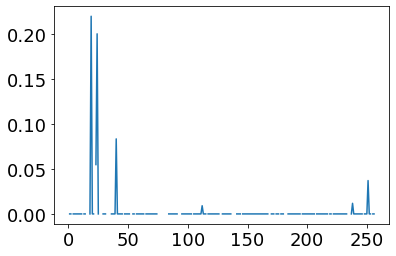

In [140]:
plt.plot(check_matches(ALDI_hash, full_spec_dB, freq, full_t, window_length=50, min_distance=20, threshold_abs=-60))

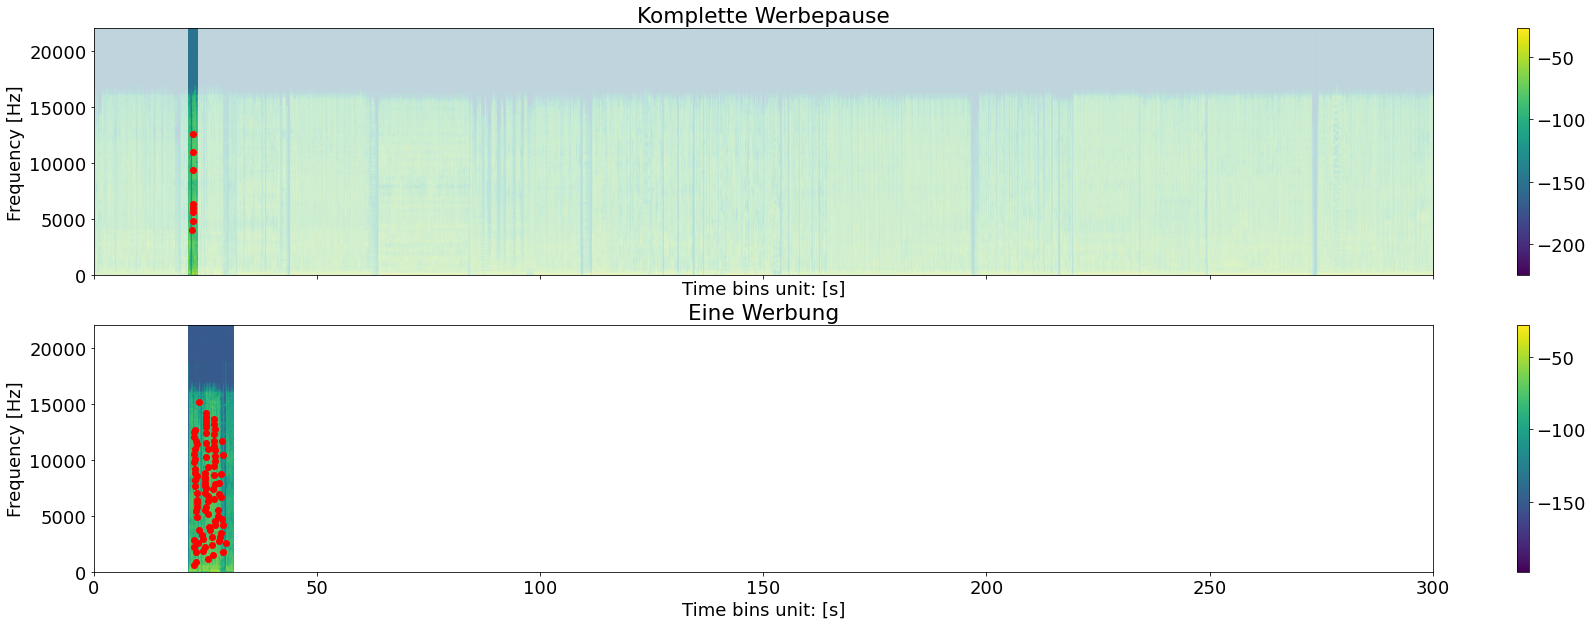

In [202]:
window_start = 452
window_length = 50
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 10), facecolor='white', sharex=True, sharey=True)
ax = axes.ravel()

# Plot the complete spectrum
im0 = ax[0].imshow(np.flipud(full_spec_dB), cmap='viridis', extent=(0, np.amax(full_t), freq[0], freq[-1]))
# Add some white shading
ax[0].broken_barh([(0, full_t[window_start]), (full_t[window_start + window_length], full_t[-1] - full_t[window_start + window_length])], (freq[0], freq[-1]), facecolors='w', alpha=.7)
# Obtain and plot the coordinates in the non-shaeded area.
freq_coords, time_coords = identify_peaks(full_spec_dB[:, window_start : window_start + window_length + 1], min_distance=20, threshold_abs=-60)
ax[0].scatter(full_t[time_coords + window_start], freq[freq_coords], color='r')

ax[0].set_xlabel('Time bins unit: [s]')
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Komplette Werbepause')
ax[0].axis('auto')
plt.colorbar(mappable=im0, ax=ax[0])

im1 = ax[1].imshow(np.flipud(ALDI_spec_dB), cmap='viridis', extent=(full_t[452], full_t[452 + ALDI_spec_dB.shape[1]], freq[0], freq[-1]))
# Obtain and plot the coordinates in the peaks
freq_coords, time_coords = identify_peaks(ALDI_spec_dB, min_distance=20, threshold_abs=-60)
ax[1].scatter(full_t[time_coords + 452], freq[freq_coords], color='r')
ax[1].set_xlabel('Time bins unit: [s]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Eine Werbung')
ax[1].axis('auto')
plt.colorbar(mappable=im1, ax=ax[1])

plt.show()